# Examine the effect of dithering patterns on differential galaxy counts#

This ipython notebook demonstrates using the 'galaxy counts' metric to calculate the number of galaxies expected at a particular point of the sky ($N$), and then postprocess these results to calculate $dN/<N>$, the variation in galaxy counts at each point. In the current implementation of the metric, these variations would be due to variation in coadded depth. 

The dithering patterns used are part of sims_maf, and are generally based on dither patterns presented by Awan, Gawiser, Kurczynski, and Carroll in https://guidebook.com/guide/28858/event/10156541/. 

This notebook assumes maf version > 1.0 is set up and available. 

--------

Import the python and MAF items we need. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# Import the contributed metrics, to get GalaxyCountsMetric
from mafContrib import GalaxyCountsMetric

Generate the metric data, for various dither patterns. See the Dithering notebook in the tutorials directory for more information on the various dither patterns available through MAF. 

First connect to an opsim output file. In this case, we're interested in running on an old output file that only contains the 'summary' table, so I'll demonstrate that here.

In [2]:
#runName = 'opsim2_168'
#dbfile = '/Users/lynnej/opsim/db_other/opsim2_168_sqlite.db'
#opsdb = mafUtils.connectOpsimDb(dbfile, summaryOnly=True)

# To connect to a more modern opsim output file we could do the following:
runName = 'enigma_1189'
dbfile = '/Users/lynnej/opsim/db/enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(dbfile)

For the purposes of this notebook, we'll only look at opsim data from the r band, and that was obtained for the WFD. For more modern sqlite files, we can identify which proposal is WFD using the utility below:  

In [3]:
propIds, propTags = opsdb.fetchPropInfo()
wfdWhere = mafUtils.createSQLWhere('WFD', propTags)
sqlconstraint  = wfdWhere + ' and filter=="r"'
print sqlconstraint

propID = 364 and filter=="r"


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression '' should be explicitly declared as text('') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})
/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression "paramName like 'ScienceTy..." should be explicitly declared as text("paramName like 'ScienceTy...") (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


For an older run with only a summary table, we have to just know the propID corresponding to WFD.

In [4]:
# sqlconstraint = 'propID=361 and filter =="r"'

---
Next, set up the slicers, metric, and MetricBundles, along with various stackers for the dithering patterns. 

In [5]:
# Set up a dictionary to hold the metric bundles, for each different dithering pattern.
myBundles = {}

In [6]:
# Set up the undithered version.
nside = 64
raCol = 'fieldRA'
decCol = 'fieldDec'
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
metric = GalaxyCountsMetric(nside=nside)
myBundles['undithered'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
                                                     runName=runName, metadata='No dithering')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
# Set up a spiral dithered version. 
raCol = 'spiralRADither'
decCol = 'spiralDecDither'
spiralstacker = stackers.SpiralDitherStacker()
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['spiral'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
                                                stackerList=[spiralstacker], runName=runName, metadata='Spiral dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
# Set up a random dither, with a specific random seed.
raCol = 'randomRADither'
decCol = 'randomDecDither'
randomstacker = stackers.RandomDitherStacker(randomSeed=43)
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['random'] = metricBundles.MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
                                                stackerList=[randomstacker], runName=runName, metadata='Random dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Calculate the metric values - remember, these are the galaxy counts in each healpix, but not scaled to $dN/<N>$.

Set up to save the output in outDir, and also to keep track of the metrics which have been run, using the resultsDb.

In [9]:
outDir = 'galaxyCounts'
resultsDb = db.ResultsDb(outDir=outDir)
mb = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)

Run the metrics.

In [10]:
mb.runAll()

Querying database with constraint propID = 364 and filter=="r"
Found 463866 visits
Running:  ['undithered']
Completed metric generation.
Running:  ['random']
Completed metric generation.
Running:  ['spiral']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'propID = 364 and filter==...' should be explicitly declared as text('propID = 364 and filter==...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


We could plot these results, or calculate summary statistics. But really what we want to do is do some post-processing to
* calculate the mean of the resulting data
* calculate the difference in galaxy counts in a healpix versus the mean, and divide by the mean (calculate $dN/<N>$)
* throw out the parts of the sky where dithering moved pointings onto a part of the sky with very few visits (remove the "ringing" around the edges)
* and it's nice to update the plot labels from 'galaxy counts' etc. to dN/N

In [11]:
# Create a 'plotHandler' object so that we can make multiple plots and easily save them/record them to the resultsDb
plotHandler = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)

undithered 166.95967729
monopole: -0.00288119  dipole: lon: 135.318, lat: -20.7199, amp: 0.016605
random 161.320866369
monopole: -0.0248129  dipole: lon: 87.9344, lat: -58.1326, amp: 0.0685077
spiral 161.934515465
monopole: -0.0232973  dipole: lon: 89.3956, lat: -57.4741, amp: 0.0643401


/Users/lynnej/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


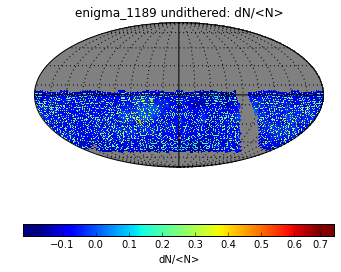

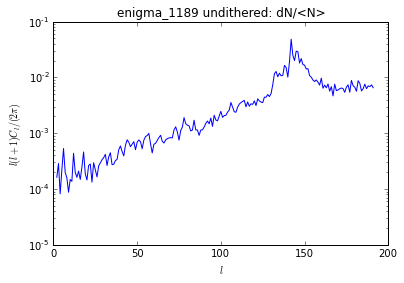

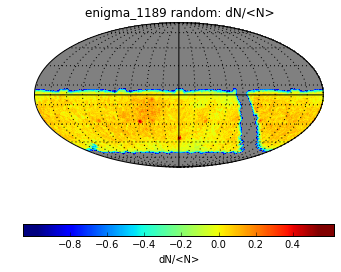

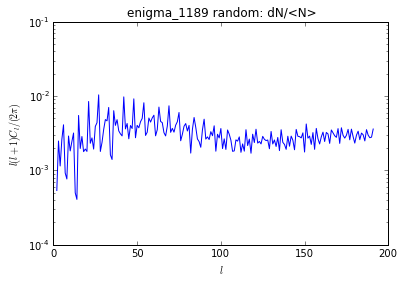

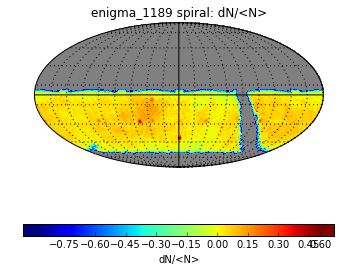

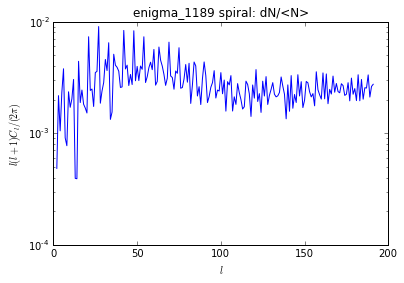

In [12]:
# Adjust metric data from galaxy counts to dN/<N>
for dither in myBundles:
    mean = myBundles[dither].metricValues.compressed().mean()
    print dither, mean
    myBundles[dither].metricValues = (myBundles[dither].metricValues - mean) / mean
    plotDict = {'xlabel':'dN/<N>', 'title':'%s %s: dN/<N>' %(runName, dither)}
    myBundles[dither].setPlotDict(plotDict)
    myBundles[dither].setPlotFuncs([plots.HealpixSkyMap(), plots.HealpixPowerSpectrum()])
    myBundles[dither].plot(plotHandler=plotHandler)

monopole: 0.0154699  dipole: lon: 94.2825, lat: -49.881, amp: 0.0341774
monopole: 0.0260938  dipole: lon: 99.6619, lat: -41.4066, amp: 0.0237124


/Users/lynnej/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


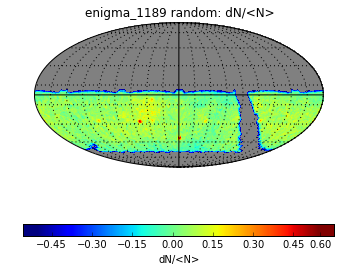

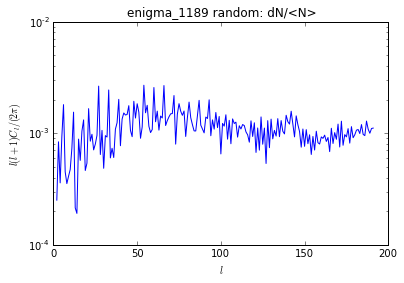

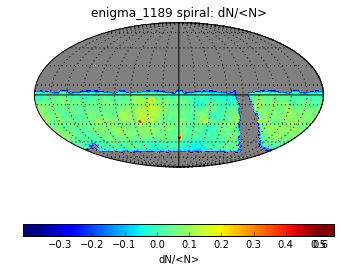

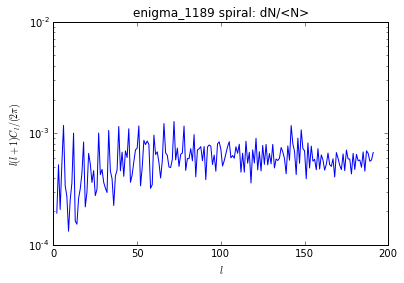

In [13]:
# Cut out the areas which moved pointings into areas of the sky which are not imaged very much (remove 'edges')
for dither in myBundles:
    # Don't cut the non-dithered case
    if dither == 'undithered':
        continue
    else:
        # Cut at 5th percentile -- just empirically determined (adjust as necessary)
        cutlevel = np.percentile(myBundles[dither].metricValues, 5.)
        newmask = np.where(myBundles[dither].metricValues < cutlevel)[0]
        # Add this to the existing mask
        myBundles[dither].metricValues.mask[newmask] = True
        myBundles[dither].plot(plotHandler=plotHandler, plotFunc=plots.HealpixSkyMap)
        myBundles[dither].plot(plotHandler=plotHandler, plotFunc=plots.HealpixPowerSpectrum)

Now we can do a few additional things: 
* calculate the total power (using the summary metric "TotalPowerMetric")
* create a plot with the power spectrum from all examples, together with the total power information in the legend.

In [14]:
summarymetric = metrics.TotalPowerMetric()
for dither in myBundles:
    myBundles[dither].setSummaryMetrics(summarymetric)
    myBundles[dither].computeSummaryStats()
    print '## Total power for %s case is %f.' %(dither, myBundles[dither].summaryValues['TotalPower'])
    # Add this to a legend label
    myBundles[dither].setPlotDict({'label':'%s total power %.3f' %(dither, 
                                                                   myBundles[dither].summaryValues['TotalPower'])})

monopole: -0.00288119  dipole: lon: 135.318, lat: -20.7199, amp: 0.016605
## Total power for undithered case is 0.772784.
monopole: 0.0154699  dipole: lon: 94.2825, lat: -49.881, amp: 0.0341774
## Total power for random case is 0.094778.
monopole: 0.0260938  dipole: lon: 99.6619, lat: -41.4066, amp: 0.0237124
## Total power for spiral case is 0.057047.


1

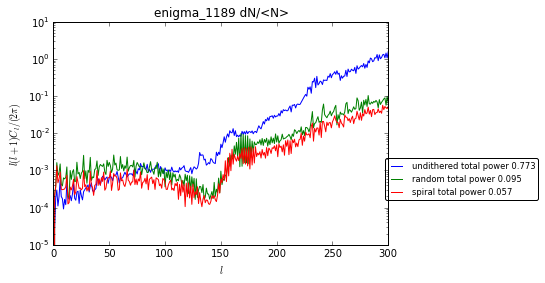

In [18]:
plotHandler.setMetricBundles(myBundles)
plotHandler.plot(plotFunc=plots.HealpixPowerSpectrum(), 
                 plotDict={'legendloc':(0.99, 0.2), 'title':'%s dN/<N>' %runName, 
                           'removeDipole':False, 'maxl':300})

In [16]:
# Look at what was written to output directory. 
!ls $outDir

enigma_1189_GalaxyCounts_No_dithering_HEAL.npz
enigma_1189_GalaxyCounts_No_dithering_HEAL_PowerSpectrum.pdf
enigma_1189_GalaxyCounts_No_dithering_HEAL_SkyMap.pdf
enigma_1189_GalaxyCounts_Random_dither_HEAL.npz
enigma_1189_GalaxyCounts_Random_dither_HEAL_Histogram.pdf
enigma_1189_GalaxyCounts_Random_dither_HEAL_PowerSpectrum.pdf
enigma_1189_GalaxyCounts_Random_dither_HEAL_SkyMap.pdf
enigma_1189_GalaxyCounts_Spiral_dither_HEAL.npz
enigma_1189_GalaxyCounts_Spiral_dither_HEAL_Histogram.pdf
enigma_1189_GalaxyCounts_Spiral_dither_HEAL_PowerSpectrum.pdf
enigma_1189_GalaxyCounts_Spiral_dither_HEAL_SkyMap.pdf
enigma_1189_GalaxyCounts_Spiral_dither_Random_dither_dithering_No_HEAL_ComboPowerSpectrum.pdf
enigma_1189_GalaxyCounts_Spiral_dither_Random_dither_dithering_No_HEAL_ComboSkyMap.pdf
resultsDb_sqlite.db
thumb.enigma_1189_GalaxyCounts_No_dithering_HEAL_PowerSpectrum.png
thumb.enigma_1189_GalaxyCounts_No_dithering_HEAL_SkyMap.png
thumb.enigma_1189_GalaxyCounts_Random_dither_HEAL_Histogram.png


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
monopole: 158.162  dipole: lon: 89.3956, lat: -57.4741, amp: 10.4189
{'Mean': 161.93451546547138}


Optimal bin calculation tried to make 332 bins, returning 200


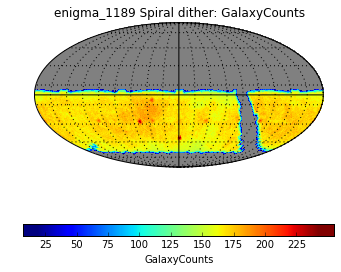

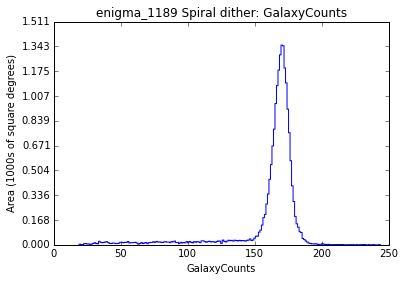

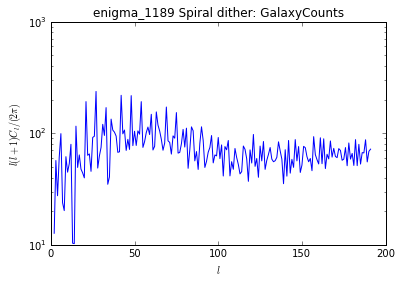

In [17]:
# And note that we could 'reboot' and read the metric information back in, then restart.
newBundle = metricBundles.MetricBundle(metric=metrics.BaseMetric(), slicer=slicers.BaseSlicer(), 
                                      sqlconstraint=sqlconstraint)
newBundle.read(os.path.join(outDir, 'enigma_1189_GalaxyCounts_Spiral_dither_HEAL.npz'))
# Note - because we wrote the data file (automatically) when doing 'runAll' this is the original galaxy counts data,
# not masked or reduced to dN/N  
newBundle.plot()
summarymetric = metrics.MeanMetric()
newBundle.setSummaryMetrics(summarymetric)
newBundle.computeSummaryStats()
print newBundle.summaryValues